# BYOL (Bootstrap Your Own Latent)

## Introduction

[Bootstrap Your Own Latent (BYOL)](https://arxiv.org/abs/2006.07733) is a novel approach in the field of self-supervised learning, particularly within the domain of computer vision. This method proposed a significant shift in how models can learn useful representations without relying on labeled data, which is particularly difficult to obtain for a lot of vision tasks.

BYOL works by creating a 2 networks, **online network** and the **target network**, which have the exact same architecture, but with different sets of weights. Both networks process the same image, albeit in different augmented forms. The online network is trained to predict the target network's representation of its version of the image. The objective of the task is to minimize the similarity loss between the prediction from the online network and the projection of the target network. This basically means that the target network is trying to teach the online network how to view different representations of the same image through different lenses. The conjecture here is that this gives the online network a richer feature representation of these images, which makes them more powerful in downstream classification/segmentation/detection tasks.

### Self-supervised learning and why it is important

Self-supervised learning (SSL) is a powerful paradigm in any machine learning task, since it aims to give useful representations from data without any annotation. In domains such as computer vision, where annotating large datasets can be prohibitively expensive and time-consuming (for context, 3rd party annotation companies [may charge upwards of €800 for 1000 images](https://kili-technology.com/data-labeling/estimating-image-annotation-pricing-for-ai-projects)), SSL offers a cost-effective alternative.

Moreover, recent advances in other machine learning domains such as NLP, Audio and sample-efficient reinforcement learning have showed that SSL is an incredibly powerful tool for the models to understand and interpret data by finding and leveraging inherent patterns and structures within the data itself. Models such as [wav2vec](https://arxiv.org/abs/2006.11477), [GPT](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf) and [BERT](https://arxiv.org/abs/1810.04805) are examples of models that are pre-trained or implemented using self-supervised methods in their pipeline.

### An overview of past self-supervised learning methods for computer vision

Inspired by methods of [knowledge distillation](https://arxiv.org/abs/1503.02531), earlier attempts at creating self-supervised learning methods for computer vision tasks were created. Knowledge distillation is a method that takes 2 neural networks - a "student" and a "teacher" -, where the goal of the task is to maximize the similiarity between the output of teacher and the student.


<p align="center">
<img src="images/knowledge-distillation.png" alt="Knowledge distillation" width="300"/>
</p>

The problem with this approach is that, if we compare two representations of the image through a loss function, there is always a local minimum that the architecture might learn that is to learn no representation at all. If both our student and teacher networks output no representations, the loss will always be equally none and, therefore, the loss will be 0. This is known as [representation collapse](https://arxiv.org/pdf/2110.09348.pdf).

Methods such as [SimCLR](https://arxiv.org/abs/2002.05709) solved this through [contrastative learning methods](https://paperswithcode.com/task/contrastive-learning), which present the networks with positive and negative samples, and train the network to maximize the distance between negative pairs while minimizing distance between positive pairs. Although had good results on paper, this mean that the dataset had to be purposely built to have negative samples and a wide range of diverse positive samples, which meant that batch sizes had to be large to provide enough representation.

<p align="center">
<img src="images/Contrastive-Learning.jpg" alt="Constrative Learning" width="300"/>
</p>


 However, BYOL comes up with a novel approach to this type of task, not having to rely on negative pairs, being able to produce oustanding results even at lower batch sizes.

### How BYOL works

BYOL expands on the notion of knowledge distillation by introducing two architecturally equal networks, the **target** (with a set of weights $\xi$) and the **online** (with a set of weights $\theta$) networks. Each network takes as input the same image but in different augumented forms, and the job of BYOL is to minimize the distance between the representation of these images.

<p align="center">
<img src="images/byol_overview.png" alt="BYOL Overview" width="400"/>
</p>

The architecture of BYOL, shown in the image below, demonstrates the stages for both the online and target networks. Both the networks have the common **encoder** $f_\theta$, **projector** $g_\theta$ heads, while the online network has a supplementary **predictor** $q_\theta$ head. The encoder $f_\theta$ is the result of our network of interest. This can range from classification networks such as [ResNet18 or ResNet50](https://arxiv.org/abs/1512.03385) or segementation networks such as [U-Net](https://arxiv.org/abs/1505.04597). 

<p align="center">
<img src="images/byol_architecture.png" alt="BYOL Architecture" width="400"/>
</p>

The projector head is a BYOL-specific module that will learn the representations of our images. The predictor head, which is only present in the online network, introduces an assymetry in the representations outputted by the two networks, which helps to avoid representation collapse.

Moreover, to maintain a stable baseline for the online network to learn, instead of training both target and online networks, it introduces a weight update mecahnism on the target network. The target network provides the regression targets to train the online network, and its parameters $\xi$ are an exponential moving average of the online parameters $\theta$. More precisely, given a target decay rate $\tau \in [0,1]$, after each training step it performs the following update:

$$\xi \leftarrow \tau\xi + (1-\tau)\theta$$

This means that the target network's weights are not actively updated through gradient descent, but are updated by computing the momentum of the online network's weights during training.

In the original BYOL paper, the exponential moving average parameter $\tau$ starts from $\tau_{base} = 0.996$ and is increased to one during training. It is set as $\tau = 1 − (1 − \tau_{base}) · (\cos(\pi k/K) + 1)/2$, with k the current training step and K the maximum number of training steps, which is a cosine scheduler.

To compare the representations of the two networks BYOL implements a loss function that computes the cosine similarity between the representations. It defines a loss $\mathcal{L}_{\theta, \xi}$ for the online $\mathcal{\tilde{L}}_{\theta, \xi}$ for the target, which is then computed between the two augmented views.

$$\mathcal{L}_{\theta, \xi} = 2 - 2 \cdot \frac{ \langle q_{\theta} (z_{\theta}), z'_{\xi} \rangle}{||q_{\theta} (z_{\theta})||_2 \cdot ||z'_{\xi}||_2}$$

$$\mathcal{L}^{BYOL}_{\theta, \xi} = \mathcal{L}_{\theta, \xi} + \mathcal{\tilde{L}}_{\theta, \xi}$$

### Performance compared to other methods

#### The Good

On both semi-supvervised and transfer learning benchmarks, performs on par or better than current state of the art (SOTA) methods. BYOL reaches 74.3% top-1 classification accuracy on ImageNet using a linear evaluation with a ResNet-50 architecture and 79.6% with a larger ResNet. When compared to previous SOTA methods such as SimCLR, BYOL was almost exclusively better in all benchmarks. It was shown to be incredibly powerful for learning representation of unlabeled data, which heavily improves training pipelines where data annotation is expensive or hard to get.

<p align="center">
<img src="images/results_byol.png" alt="BYOL Results" width="600"/>
</p>

#### The Bad

Although it shows promising results, BYOL still has some implementation pitfalls that may be problematic. 

BYOL's architecture, which includes an online network and a target network, along with a prediction head, increases the model's complexity and therefore the required computational power to run these methods. For larger downstream networks, computing power may be a limiting factor. Moreover, the need to maintain and update two networks simultaneously during training can lead to higher memory usage and increased processing time, making it challenging to train on large datasets or with limited hardware.

BYOL also heavily relies on sets of data augmentation for the model to learn proximal representations. Designing effective augmentations requires domain knowledge, and finding the right set of augmentations can be a trial-and-error process, adding an additional layer of complexity to the training procedure. Poorly chosen augmentations can lead to suboptimal learning outcomes.

#### The Ugly

Perhaps the most controversial part of BYOL is that its results are purely emprical, and the reason for success - in the theoretical sense - is still a mystery for researchers. Although representation collapse is mitigated in the examples, in theory there is **no reason why it shouldn't occur at any given time**. In fact, the authors of BYOL explicitly quote:

> “While this objective admits collapsed solutions, e.g., outputting the same vector for all images, we empirically show that BYOL does not converge to such solutions.”

The authors hypothesize that the use of a predictor head and the use of a slow-moving average to update the target network avoids collapsed solutions, but no proof has yet been shown.








## Implementing BYOL

**Note:** 
1. To simplify this notebook and faciliate training, all implementations are on `byol` directory shipped with this notebook. For clarity, prints of the classes and modules will be shown here, but you may go to the project directory to see all of the implementation.
2. The implementation of the modules are done using Pytorch Lightning to simplify the ammount of training code.


### The Heads

As seem by its architecture, BYOL has 3 main heads: the encoder, the projector and the predictor.

#### The Encoder

The encoder (or backbone), is the actual network that will perform the classification, segmentation or detection task. For this example, we will use a image classification task in which a ResNet18 architecture is applied. We choose this architecture because it is simple, already implemented through the `torchvision` library and lightweight, allowing runs to be kept simple for this notebook.

<p align="center">
<img src="images/resnet_module.png" alt="Resnet Module" width="600"/>
</p>

#### The Projection Head

The projection head is made up of an Multi-layer perceptron (MLP) that consists of a linear layer followed by a batch normalizaiton and a ReLU non-linearity. The input dimension is the dimension of the image. This is then fed through the hidden layer with more dimensions, and then compressed again to an output layer.

In the paper, the authors use an input with a feature dimension of 2048 because they train on bigger networks such as ResNet50, which has an output size of 2048. For the hidden layer, they used a linear layer with output size 4096. However, in this example we will train using a ResNet18 which has an output size of 512, so `input_dim` will be 512. To simplify the training process as well, we will use a hidden dimension of 1024. The output dimension of this head is 256.

<p align="center">
<img src="images/ProjectionHead.png" alt="Projection Head" width="600"/>
</p>

#### The Prediction Head

The prediction head has exactly the same structure as the projection head, but the input dimension now is exactly equal to the output dimension of the previous head, which is the projection head. Therefore, the input dimension will be 256.


<p align="center">
<img src="images/PredictionHead.png" alt="Projection Head" width="600"/>
</p>


### The Transforms

BYOL uses a series of data augmentations (or transforms) that enable the model to learn invariant features by predicting the representation of one augmented view from another. Although these augmentations are dependant on the type of task and data, we will use the default augmentations used in the paper for the classification task. These augmentations are: resize and crop, horizontal flip, color jitter and grayscale. The image below illustrates some of the common augmentations used.

<p align="center">
<img src="images/augmentations.png" alt="Augmentations" width="400"/>
</p>

We then implement these transforms as their own class and apply it to our dataloader as such. It is important to note here that the default input size for the transform is 224 because ResNet18, by default, resizes the input image to a vector of dimension 224.

<p align="center">
<img src="images/ByolTransforms.png" alt="Transforms" width="500"/>
</p>

### The BYOL Module

With the all the heads and transforms, we can then put it all together into a BYOL module, that encapsulates it all. 

First, we define and intialize our heads. Since we have the online and target networks, we will need 2 encoders (`backbone` and `target_backbone`), 2 projection heads (`projection head` and `target_projection_head`) and 1 prediction head for the online network (`prediction head`).

<p align="center">
<img src="images/Byol1.png" alt="Transforms" width="500"/>
</p>

Then, since the target network is not trained using gradient descent but its weights are updated based on the momentum of the online network's weights, we have to deactivate the gradients for all the parameters of the target.

We also define a helper to our loss function, which is the cosine similarity module, which computes the function $\text{similarity} = \dfrac{x_1 \cdot x_2}{\max(\Vert x_1 \Vert _2 \cdot \Vert x_2 \Vert _2, \epsilon)}$.

Our `forward` and `forward_target` calls are then just the application of the pipeline seen on our architecture. For the online network, the input goes through the encoder, projector and finally predictor heads. For the target, it only goes through the encoder and projection heads.

<p align="center">
<img src="images/Byol2.png" alt="Transforms" width="500"/>
</p>

Finally, one training step for BYOL looks like the following:

1. Fetch the current momentum variable $\tau$.
2. Update the momentum on the target network (backbone and projection head).
3. Forward through input through the target and online networks.
4. Compute the similarity loss between the two.

<p align="center">
<img src="images/Byol3.png" alt="Transforms" width="500"/>
</p>


## Putting it to practice

Let's see how BYOL works in practice. We'll compare two image classification tasks: 
- a simple ResNet18 model trained on a subset of the CIFAR10 data.
- a BYOL-boosted ResNet18 trained on non-labelled CIFAR10 images and later finetuned on the same subset of previous task.

Hopefully, the BYOL model will be able to extract feature representations from the unlabelled data and "teach" our ResNet18 model a more complete representation of the probability distribution when we finetune it on the labelled images. We should see better testing results for our BYOL-boosted model.

Here's our training pipeline for this notebook:

1. Start with a full dataset of CIFAR-10 training data $D$. 
2. Train a supervised task with resnet18 on a subset $A$ of $D$ and log its score on the test set $T$.
3. Train a unsupervised task with BYOL on a subset $B$ of $D$ (where $D = A \cup B$) and log the the model. 
4. Finetune the BYOL-enhanced model with a supervised task on resnet 18 on the subset $A$. Log its score on test set $T$.
5. Compare results between baseline and finetuned model.

**Note**: We will train for only 3 epochs on all tasks to save some time. I believe that training for longer will yield better results, but we don't have much time, so that will have to do.

In [1]:
import sys

sys.path.append("./../")

from byol.models import BYOL, ResNetModule
from byol.utils import BYOLTransforms1, BYOLTransforms
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np

accelerator = "gpu" if torch.cuda.is_available() else "cpu"


/home/rafael/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pure Resnet on CIFAR-10 classification task

The CIFAR-10 is an open collection of images often used for computer vision benchmarks. The dataset contains 60,000 32x32 color images in 10 different classes.

<p align="center">
<img src="images/CIFAR10.png" alt="Cifar" width="300"/>
</p>




Let's start by setting a baseline of a classification task of our model's backbone. We are using resnet18 here as our backone, so let's see how it performs on a subset of the CIFAR-10 data.


#### Step 1. Data

In [2]:
no_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=no_transform)
cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=no_transform)
cifar10_dataset


Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Creating subsets $A$ and $B$.

In [3]:
A_indices = np.random.choice(len(cifar10_dataset), int(len(cifar10_dataset)/2), replace=False)
cifar10_subset_A = torch.utils.data.Subset(cifar10_dataset, A_indices)
train_test_split = 0.8
train_size = int(len(cifar10_subset_A)*train_test_split)
val_size = len(cifar10_subset_A) - train_size
train_dataset_A, val_dataset_A = torch.utils.data.random_split(cifar10_subset_A, [train_size, val_size])

Dataloaders for supervised task.

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset_A, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset_A, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### Step 2: Training ResNet model

In [5]:
resnet_module = ResNetModule()

resnet_trainer = pl.Trainer(
    max_epochs=3,
    devices=1,
    accelerator=accelerator,
)

#resnet_trainer.fit(model=resnet_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/rafael/miniconda3/envs/gengar/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rafael/miniconda3/envs/gengar/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Step 3: Training BYOL model on unlabelled data.

In [6]:
transform = BYOLTransforms(
    view1=BYOLTransforms1(input_size=32),
    view2=BYOLTransforms1(input_size=32)
)

cifar10_dataset_byol = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
B_indices = np.setdiff1d(np.arange(len(cifar10_dataset)), A_indices)
cifar10_subset_B = torch.utils.data.Subset(cifar10_dataset_byol, B_indices)
byol_batch_size = 2048 # byol batch size is usually a lot larger than the supervised batch size
byol_dataloader = torch.utils.data.DataLoader(cifar10_subset_B, batch_size=byol_batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [7]:
byol_module = BYOL(
    model=resnet_module.model
)

byol_trainer = pl.Trainer(
    max_epochs=5,
    devices=1,
    accelerator=accelerator,
)

byol_trainer.fit(model=byol_module, train_dataloaders=byol_dataloader) # our model never sees labeled data!

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-03-02 00:28:58.552623: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 00:28:58.627617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 00:28:59.819768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type               | Params
--------------------------------------------------------------
0 | backbone               | Sequential         | 11.2 M
1 | target_backbone        | S

Epoch 4: 100%|██████████| 13/13 [00:19<00:00,  0.66it/s, v_num=37, train_loss=-.538]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 13/13 [00:19<00:00,  0.66it/s, v_num=37, train_loss=-.538]


### Step 4. Finetune BYOL-enhanced baseline on ResNet

In [8]:
byol_resnet = ResNetModule.from_byol(byol_module)

byol_resnet_trainer = pl.Trainer(
    max_epochs=3,
    devices=1,
    accelerator=accelerator,
)

byol_resnet_trainer.fit(model=byol_resnet, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/rafael/miniconda3/envs/gengar/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rafael/miniconda3/envs/gengar/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 11.2 M
-------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.706    Total estimated

Epoch 2: 100%|██████████| 625/625 [00:21<00:00, 28.49it/s, v_num=38, val_loss=1.210, train_loss=1.250]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 625/625 [00:22<00:00, 28.04it/s, v_num=38, val_loss=1.210, train_loss=1.250]


### Step 5. Testing both models on test dataset.

In [9]:
predict_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=predict_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


Files already downloaded and verified


In [10]:
resnet_trainer.test(model=resnet_module, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 0/313 [00:00<?, ?it/s]

RuntimeError: Detected more unique values in `preds` than `num_classes`. Expected only 10 but found 23 in `preds`.

In [ ]:
byol_resnet_trainer.test(model=byol_resnet, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.6769999861717224     │
│         test_loss         │    0.9869425892829895     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.6769999861717224, 'test_loss': 0.9869425892829895}]

As we can see, BYOL was able to improve our base model by only looking at unlabeled images!

Let's take a look at some examples to see what both models are doing here.

In [ ]:
num_samples = 10
indices = np.random.choice(len(test_dataset), num_samples, replace=False)
subset_test_dataset = torch.utils.data.Subset(test_dataset, indices)
subset_test_dataloader = torch.utils.data.DataLoader(
    subset_test_dataset, 
    batch_size=2,
    num_workers=8,
    shuffle=False
)

In [ ]:
resnet_predictions = resnet_trainer.predict(model=resnet_module, dataloaders=subset_test_dataloader)
byol_resnet_predictions = byol_resnet_trainer.predict(model=byol_resnet, dataloaders=subset_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

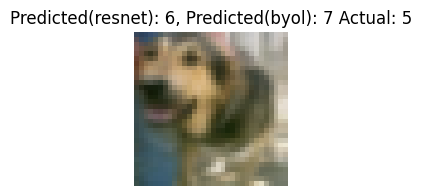

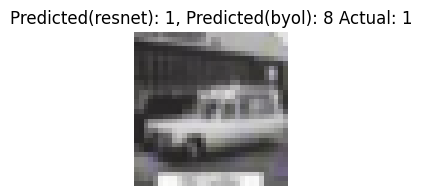

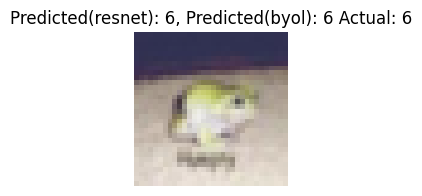

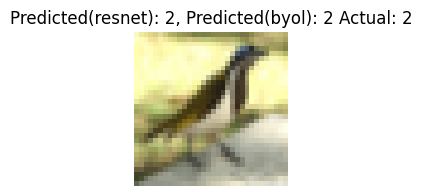

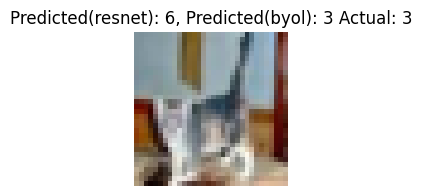

In [ ]:
import matplotlib.pyplot as plt

resnet_predicted_labels = torch.argmax(torch.cat(resnet_predictions, dim=0), dim=1)
byol_resnet_predicted_labels = torch.argmax(torch.cat(byol_resnet_predictions, dim=0), dim=1)

# Select a few images to display
num_images_to_display = 5
for i in range(num_images_to_display):
    image, label = subset_test_dataset[i]
    resnet_pred_label = resnet_predicted_labels[i]
    byol_resnet_pred_label = byol_resnet_predicted_labels[i] 

    np_image = image.numpy().transpose((1, 2, 0))
    np_image = np.clip(np_image * 0.5 + 0.5, 0, 1) 

    plt.figure(figsize=(2, 2))
    plt.imshow(np_image)
    plt.title(f'Predicted(resnet): {resnet_pred_label}, Predicted(byol): {byol_resnet_pred_label} Actual: {label}')
    plt.axis('off')
    plt.show()

# Conclusion and takeaways

Through a comparative analysis between a conventionally trained ResNet model and a BYOL-boosted ResNet model, we have demonstrated the tangible benefits of leveraging self-supervised pre-training for improving the performance of downstream computer vision tasks.

The conventional ResNet model, trained on a subset comprising half of the CIFAR-10 dataset images for three epochs, served as our baseline. In contrast, the BYOL-boosted model underwent an initial self-supervised learning phase on the disjoint half of the CIFAR-10 dataset, followed by fine-tuning on the same subset used for the baseline model. The outcomes were revealing, showcasing a significant enhancement in model performance post-BYOL pre-training, as evidenced by both decreased loss and increased accuracy metrics.

This experiment highlights some very enlightning findings:

1. The effectiveness of self-supervised pre-training in enriching the base model's ability to discern and generalize from the visual data.
2. Modern self-supervised methods are incredibly powerful at leveraging unlabeled data for learning feature representations, posing a significant shift in how models are trained, particularly when the available labeled data is limited or costly to obtain.

However, it is important to keep in mind the limitations and pitfalls of methods like these, which were also highlighted in this notebook:

1. Self-supervised learning is sometimes poorly understood, and may not behave as expected. Particularly for BYOL, there's a good ammount of variance related to choosing the right transforms and hyperparameters for it to produce significant feature representations and avoid representation collapse.
2. Fully supervised methods are still the best when the dataset is equally balanced. This notebook simulates the situation that our models only have access to a subset of images that are labeled. However, if we re-did the experiment and trained the pure ResNet model on the entirety of the dataset, it is sure that it will outperform the BYOL-Boosted model.

In conclusion, BYOL underscores the transformative potential of self-supervised learning in the field of computer vision. By enabling more efficient utilization of unlabeled data and significantly enhancing model performance on supervised tasks, BYOL presents a compelling approach for future research and application in machine learning workflows.

